Exercise 8
===
Let's create an autoencoder network that pretrains on MNIST images.

In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def create_next_batch_fn(data, sequence_lengths, targets, batch_size):
    assert len(data) == len(sequence_lengths) and len(data) == len(targets)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(data)
        return data[i:i+batch_size], sequence_lengths[i:i+batch_size], targets[i:i+batch_size]
    return next_batch

In [44]:
import math

# Constants
input_spatial_size = 28
input_channels = 1
batch_size = 5

# Hyperparameters
learning_rate = 0.001
n_hidden_neurons = 600
l2_reg = 0.000001

initializer = tf.contrib.layers.variance_scaling_initializer()
activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

with tf.device("/gpu:0"):
    n_input_neurons = input_spatial_size ** 2
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input") 
    weights1 = initializer([n_input_neurons, n_hidden_neurons])
    biases1 = tf.Variable(tf.zeros(n_hidden_neurons))
    n_output_neurons = n_input_neurons
    weights2 = initializer([n_hidden_neurons, n_output_neurons])
    biases2 = tf.Variable(tf.zeros(n_output_neurons))
    
    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    outputs = tf.matmul(hidden1, weights2) + biases2

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        regularisation_loss = regularizer(weights1) + regularizer(weights2)
        loss = reconstruction_loss + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 20
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t, l = sess.run([training_op, loss], feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_autoencoder_model_final.ckpt")

epoch 0
loss: 0.356784
loss: 0.352021
loss: 0.458634
loss: 0.264009
loss: 0.326034
loss: 0.405123
loss: 0.239859
loss: 0.33282
loss: 0.356639
loss: 0.241718
loss: 0.295366
loss: 0.283776
loss: 0.273948
loss: 0.31496
loss: 0.269471
loss: 0.2429
loss: 0.302039
loss: 0.292545
loss: 0.221675
loss: 0.233776
loss: 0.313057
loss: 0.242308
loss: 0.212942
loss: 0.289323
loss: 0.247995
loss: 0.228654
loss: 0.234172
loss: 0.158537
loss: 0.220219
loss: 0.251602
loss: 0.240835
loss: 0.253162
loss: 0.208586
loss: 0.188144
loss: 0.252151
loss: 0.204072
loss: 0.189273
loss: 0.213365
loss: 0.203258
loss: 0.217182
loss: 0.176736
loss: 0.209407
loss: 0.145824
loss: 0.268729
loss: 0.237139
loss: 0.160856
loss: 0.1807
loss: 0.191376
loss: 0.178809
loss: 0.164007
loss: 0.155848
loss: 0.215184
loss: 0.245853
loss: 0.222116
loss: 0.20172
loss: 0.14237
loss: 0.15797
loss: 0.131868
loss: 0.115227
loss: 0.100789
loss: 0.152036
loss: 0.103649
loss: 0.191375
loss: 0.108655
loss: 0.108186
loss: 0.16282
loss: 0.1366

loss: 0.0789935
loss: 0.0505788
loss: 0.0703855
loss: 0.0596429
loss: 0.0697567
loss: 0.0707118
loss: 0.0622462
loss: 0.0679167
loss: 0.0711721
loss: 0.0787699
loss: 0.0634287
loss: 0.0625638
loss: 0.0750217
loss: 0.0654014
loss: 0.0755844
loss: 0.0711
loss: 0.0535115
loss: 0.0694702
loss: 0.0636258
loss: 0.065362
loss: 0.0601858
loss: 0.0891032
loss: 0.0582469
loss: 0.0561014
loss: 0.0794044
loss: 0.0819255
loss: 0.0669566
loss: 0.0683423
loss: 0.0603335
loss: 0.0794228
loss: 0.0673504
loss: 0.0706952
loss: 0.0546403
loss: 0.081613
loss: 0.0909449
loss: 0.0678185
loss: 0.0601721
loss: 0.0537504
loss: 0.0691096
loss: 0.075935
loss: 0.0806958
loss: 0.0831237
loss: 0.0712768
loss: 0.060224
loss: 0.0961487
loss: 0.073093
loss: 0.0728472
loss: 0.0533051
loss: 0.0541873
loss: 0.0797717
loss: 0.0737601
loss: 0.0689928
loss: 0.0612052
loss: 0.0602438
loss: 0.0577335
loss: 0.0597242
loss: 0.0726739
loss: 0.0771886
loss: 0.0728564
loss: 0.0865965
loss: 0.066701
loss: 0.0770372
loss: 0.0715401
l

loss: 0.0632034
loss: 0.0594116
loss: 0.0609526
loss: 0.0705263
loss: 0.0713255
loss: 0.0670085
loss: 0.0670216
loss: 0.0664804
loss: 0.0847138
loss: 0.0587156
loss: 0.0541356
loss: 0.0646157
loss: 0.0581152
loss: 0.0629057
loss: 0.0777922
loss: 0.0529181
loss: 0.0889888
loss: 0.0609132
loss: 0.0686002
loss: 0.0802104
loss: 0.0595664
loss: 0.0595333
loss: 0.0694593
loss: 0.0546114
loss: 0.0889791
loss: 0.0614834
loss: 0.064886
loss: 0.0583563
loss: 0.0784717
loss: 0.0614663
loss: 0.0738274
loss: 0.0611665
loss: 0.0748857
loss: 0.0588128
loss: 0.066703
loss: 0.074123
loss: 0.0635916
loss: 0.0588014
loss: 0.073358
loss: 0.059656
loss: 0.0559547
loss: 0.0643087
loss: 0.0629795
loss: 0.0754334
loss: 0.0728351
loss: 0.0787282
loss: 0.0734349
loss: 0.0828985
epoch 1
loss: 0.0723075
loss: 0.0553093
loss: 0.069929
loss: 0.0666551
loss: 0.0658308
loss: 0.0906279
loss: 0.0819382
loss: 0.0642391
loss: 0.0599864
loss: 0.0630915
loss: 0.0658746
loss: 0.074096
loss: 0.0573231
loss: 0.0615082
loss: 0

loss: 0.0557049
loss: 0.0631063
loss: 0.0560943
loss: 0.066799
loss: 0.0774516
loss: 0.0572542
loss: 0.0822874
loss: 0.0600846
loss: 0.0661633
loss: 0.0764079
loss: 0.0697657
loss: 0.066971
loss: 0.0645944
loss: 0.0653575
loss: 0.0607103
loss: 0.0676255
loss: 0.0617351
loss: 0.0634206
loss: 0.078341
loss: 0.0681656
loss: 0.100489
loss: 0.0667137
loss: 0.0768608
loss: 0.0537035
loss: 0.0731889
loss: 0.0636385
loss: 0.0647303
loss: 0.071569
loss: 0.0650101
loss: 0.0763497
loss: 0.0717408
loss: 0.0565066
loss: 0.0637695
loss: 0.0660692
loss: 0.0627473
loss: 0.058448
loss: 0.0950165
loss: 0.063609
loss: 0.0783574
loss: 0.0669779
loss: 0.0780717
loss: 0.0596384
loss: 0.072886
loss: 0.0642201
loss: 0.066506
loss: 0.0626101
loss: 0.0561235
loss: 0.0714081
loss: 0.0712023
loss: 0.0768541
loss: 0.0771872
loss: 0.0638218
loss: 0.0684707
loss: 0.0653881
loss: 0.0642612
loss: 0.0627785
loss: 0.0730563
loss: 0.073703
loss: 0.0779703
loss: 0.0766844
loss: 0.0642556
loss: 0.0708675
loss: 0.0720819
lo

loss: 0.0684794
loss: 0.0691991
loss: 0.0770332
loss: 0.0689798
loss: 0.070082
loss: 0.0633072
loss: 0.0667567
loss: 0.0666275
loss: 0.0497992
loss: 0.0591211
loss: 0.062686
loss: 0.0592119
loss: 0.0603755
loss: 0.0797083
loss: 0.0677056
loss: 0.0728338
loss: 0.0704678
loss: 0.0590264
loss: 0.0572574
loss: 0.0637529
loss: 0.0615383
loss: 0.0694468
loss: 0.0695042
loss: 0.0764458
loss: 0.0793107
loss: 0.0722953
loss: 0.0702972
loss: 0.0807643
loss: 0.06373
loss: 0.085598
loss: 0.0870728
loss: 0.0609349
loss: 0.0747589
loss: 0.0710856
loss: 0.0739026
loss: 0.0714034
loss: 0.0723636
loss: 0.0584797
loss: 0.0620776
loss: 0.0737124
loss: 0.0780777
loss: 0.055961
loss: 0.0577422
loss: 0.0678074
loss: 0.0627258
loss: 0.0722661
loss: 0.0584252
loss: 0.0605122
loss: 0.0801359
loss: 0.0665872
loss: 0.0805988
loss: 0.0848158
loss: 0.0606796
loss: 0.0580262
loss: 0.0684838
loss: 0.061263
loss: 0.0673456
loss: 0.0831139
loss: 0.0654205
loss: 0.080027
loss: 0.0574997
loss: 0.0775415
loss: 0.0615248


loss: 0.0588103
loss: 0.0542268
loss: 0.0607316
loss: 0.0483731
loss: 0.0680018
loss: 0.0627968
loss: 0.0592239
loss: 0.052539
loss: 0.0655645
loss: 0.0643571
loss: 0.0608593
loss: 0.0601566
loss: 0.0627826
loss: 0.0666691
loss: 0.0726967
loss: 0.0652713
loss: 0.0651916
loss: 0.0766573
loss: 0.0661194
loss: 0.0627989
loss: 0.0897557
loss: 0.0679006
loss: 0.0726382
loss: 0.0587725
loss: 0.078734
loss: 0.0591831
loss: 0.0727662
loss: 0.0653971
loss: 0.0706754
loss: 0.0937687
loss: 0.0692945
loss: 0.0728203
loss: 0.0602849
loss: 0.073684
loss: 0.0641699
loss: 0.0733759
loss: 0.0628749
loss: 0.0836709
loss: 0.0818949
loss: 0.0680471
loss: 0.0663377
loss: 0.066892
loss: 0.0761069
loss: 0.0800122
loss: 0.0671286
loss: 0.0695344
loss: 0.0977918
loss: 0.0624045
loss: 0.066714
loss: 0.0639192
loss: 0.0652291
loss: 0.0961168
loss: 0.0715396
loss: 0.0716598
loss: 0.0853096
loss: 0.0679953
loss: 0.0638672
loss: 0.0588231
loss: 0.0639005
loss: 0.0644124
loss: 0.065216
loss: 0.0676408
loss: 0.072357

loss: 0.0732355
loss: 0.0614358
loss: 0.0588178
loss: 0.0706095
loss: 0.0661114
loss: 0.064167
loss: 0.0734278
loss: 0.0863247
loss: 0.0736622
loss: 0.055248
loss: 0.0718791
loss: 0.0703351
loss: 0.0532691
loss: 0.0712255
loss: 0.0595224
loss: 0.0867263
loss: 0.0668016
loss: 0.0617474
loss: 0.071777
loss: 0.0757857
loss: 0.0694599
loss: 0.064262
loss: 0.0630258
loss: 0.0724801
loss: 0.0653245
loss: 0.0580448
loss: 0.0760408
loss: 0.0630402
loss: 0.0538842
loss: 0.0733425
loss: 0.068203
loss: 0.0768561
loss: 0.0719675
loss: 0.0681671
loss: 0.0611671
loss: 0.0780017
loss: 0.0758003
loss: 0.0729514
loss: 0.0587272
loss: 0.0722501
loss: 0.0653278
loss: 0.0734346
loss: 0.0858098
loss: 0.060256
loss: 0.0591357
loss: 0.0687802
loss: 0.0717959
loss: 0.069285
loss: 0.0886606
loss: 0.0729519
loss: 0.0636163
loss: 0.0706157
loss: 0.0731565
loss: 0.0689096
loss: 0.0646363
loss: 0.0914524
loss: 0.0662602
loss: 0.0681247
loss: 0.0687718
loss: 0.0635185
loss: 0.0648834
loss: 0.0569557
loss: 0.068881


loss: 0.0749445
loss: 0.0826146
loss: 0.0645491
loss: 0.0712658
loss: 0.0747763
loss: 0.0585483
loss: 0.0708935
loss: 0.0926225
loss: 0.0776831
loss: 0.0655102
loss: 0.0595985
loss: 0.0517678
loss: 0.0740249
loss: 0.0607786
loss: 0.0549415
loss: 0.0519786
loss: 0.0700161
loss: 0.0736525
loss: 0.0859519
loss: 0.0592541
loss: 0.0700043
loss: 0.0693191
loss: 0.0902864
loss: 0.0606811
loss: 0.0560977
loss: 0.0780915
loss: 0.080142
loss: 0.0694072
loss: 0.0765363
loss: 0.0662447
loss: 0.0609478
loss: 0.0515017
loss: 0.0715762
loss: 0.0639641
loss: 0.0629343
loss: 0.055776
loss: 0.0763846
loss: 0.0728344
loss: 0.0595362
loss: 0.0644534
loss: 0.0667701
loss: 0.0660587
loss: 0.0721603
loss: 0.0676272
loss: 0.079945
loss: 0.0827701
loss: 0.0565144
loss: 0.0516655
loss: 0.0672273
loss: 0.0679948
loss: 0.0703762
loss: 0.0715025
loss: 0.0561127
loss: 0.0609588
loss: 0.0647311
loss: 0.0716932
loss: 0.0579536
loss: 0.0919062
loss: 0.06562
loss: 0.0690003
loss: 0.0547632
loss: 0.0887974
loss: 0.09246

loss: 0.0637523
loss: 0.0909465
loss: 0.0828642
loss: 0.0786046
loss: 0.0704322
loss: 0.0662407
loss: 0.0754441
loss: 0.0665798
loss: 0.0683188
loss: 0.0769932
loss: 0.0690308
loss: 0.0644351
loss: 0.067474
loss: 0.0761188
loss: 0.0539849
loss: 0.0814792
loss: 0.0711074
loss: 0.0711792
loss: 0.0705405
loss: 0.0637789
loss: 0.0577966
loss: 0.0617729
loss: 0.0854392
loss: 0.0762128
loss: 0.0575214
loss: 0.0606206
loss: 0.0742078
loss: 0.080998
loss: 0.0737844
loss: 0.067413
loss: 0.0716554
loss: 0.0646162
loss: 0.0734027
loss: 0.0629046
loss: 0.0558782
loss: 0.0538351
loss: 0.0731493
loss: 0.0544563
loss: 0.0685783
loss: 0.066919
loss: 0.071196
loss: 0.0847327
loss: 0.0704
loss: 0.067381
loss: 0.0718147
loss: 0.0634168
loss: 0.0676839
loss: 0.0741773
loss: 0.0675622
loss: 0.0633344
loss: 0.0625373
loss: 0.061672
loss: 0.0744461
loss: 0.071007
loss: 0.0816506
loss: 0.0665477
loss: 0.0754453
loss: 0.0780617
loss: 0.0613198
loss: 0.0756987
loss: 0.0779141
loss: 0.0651535
loss: 0.0645099
los

loss: 0.0663121
loss: 0.0736344
loss: 0.0660059
loss: 0.0670186
loss: 0.0607771
loss: 0.0673733
loss: 0.077229
loss: 0.0696846
loss: 0.0807942
loss: 0.075315
loss: 0.0697226
loss: 0.0575797
loss: 0.0570704
loss: 0.0789098
loss: 0.0827048
loss: 0.0601542
loss: 0.0650243
loss: 0.0726309
loss: 0.0623262
loss: 0.0737489
loss: 0.0636582
loss: 0.0764523
loss: 0.0568036
loss: 0.102501
loss: 0.0816547
loss: 0.0769365
loss: 0.0579837
loss: 0.0668496
loss: 0.0657678
loss: 0.0605555
loss: 0.0805776
loss: 0.0701291
loss: 0.0632997
loss: 0.085673
loss: 0.0755633
loss: 0.0664711
loss: 0.0738464
loss: 0.0686156
loss: 0.063507
loss: 0.0821296
loss: 0.0602915
loss: 0.0626693
loss: 0.0729771
loss: 0.0739117
loss: 0.0538542
loss: 0.0572496
loss: 0.0829151
loss: 0.0644853
loss: 0.0730854
loss: 0.0665567
loss: 0.0561531
loss: 0.0617569
loss: 0.0780254
loss: 0.0591245
loss: 0.0608092
loss: 0.0605155
loss: 0.0622322
loss: 0.0656479
loss: 0.0653462
loss: 0.0743706
loss: 0.0626003
loss: 0.0701532
loss: 0.08501

loss: 0.0688747
loss: 0.071136
loss: 0.0730675
loss: 0.0663487
loss: 0.0800664
loss: 0.0696215
loss: 0.0740748
loss: 0.0709196
loss: 0.0663073
loss: 0.0805883
loss: 0.0696368
loss: 0.0615789
loss: 0.0640547
loss: 0.0686906
loss: 0.0720218
loss: 0.059757
loss: 0.0585579
loss: 0.0630848
loss: 0.0769175
loss: 0.0691714
loss: 0.0540815
loss: 0.0835571
loss: 0.0535659
loss: 0.0540084
loss: 0.0827987
loss: 0.0677961
loss: 0.0729126
loss: 0.0662894
loss: 0.0859915
loss: 0.0584198
loss: 0.0612773
loss: 0.0686213
loss: 0.0631993
loss: 0.0707384
loss: 0.0605341
loss: 0.0685193
loss: 0.0698483
loss: 0.0758744
loss: 0.0630401
loss: 0.0673271
loss: 0.0740334
loss: 0.0649282
loss: 0.0711459
loss: 0.0653399
loss: 0.0738879
loss: 0.0665554
loss: 0.0779339
loss: 0.0645313
loss: 0.0538079
loss: 0.0607289
loss: 0.0701387
loss: 0.0769379
loss: 0.0592041
loss: 0.0708496
loss: 0.0690201
loss: 0.0771409
loss: 0.0755881
loss: 0.067466
loss: 0.0683802
loss: 0.0632925
loss: 0.0659475
loss: 0.0599504
loss: 0.082

loss: 0.0662917
loss: 0.0556925
loss: 0.0631387
loss: 0.0728949
loss: 0.0730314
loss: 0.0865536
loss: 0.077455
loss: 0.066936
loss: 0.0735807
loss: 0.0712891
loss: 0.0676678
loss: 0.0626893
loss: 0.0594352
loss: 0.0574726
loss: 0.0640808
loss: 0.0757312
loss: 0.0605309
loss: 0.0767681
loss: 0.0662591
loss: 0.0630644
loss: 0.0733115
loss: 0.059903
loss: 0.0661194
loss: 0.0793721
loss: 0.0764603
loss: 0.064946
loss: 0.0600634
loss: 0.0686619
loss: 0.0687204
loss: 0.0581644
loss: 0.0631357
loss: 0.0697691
loss: 0.0788119
loss: 0.0506629
loss: 0.0694108
loss: 0.0648043
loss: 0.060142
loss: 0.0785017
loss: 0.0557725
loss: 0.0779794
loss: 0.0543504
loss: 0.0634921
loss: 0.0589804
loss: 0.063759
loss: 0.0519111
loss: 0.0681122
loss: 0.070791
loss: 0.0653872
loss: 0.0703354
loss: 0.0773665
loss: 0.0663917
loss: 0.0630513
loss: 0.0875693
loss: 0.0651399
loss: 0.0729526
loss: 0.0681511
loss: 0.0857973
loss: 0.0694813
loss: 0.0629365
loss: 0.0568407
loss: 0.0691216
loss: 0.060682
loss: 0.0716186


loss: 0.0762627
loss: 0.0576674
loss: 0.0847646
loss: 0.0647466
loss: 0.0684224
loss: 0.0651367
loss: 0.0668249
loss: 0.0645903
loss: 0.0567319
loss: 0.0855791
loss: 0.0614928
loss: 0.0598317
loss: 0.069249
loss: 0.0871533
loss: 0.0533444
loss: 0.059816
loss: 0.0680546
loss: 0.0674529
loss: 0.0732478
loss: 0.0701239
loss: 0.0544441
loss: 0.0707573
loss: 0.0686833
loss: 0.0858302
loss: 0.0599435
loss: 0.0779526
loss: 0.0745217
loss: 0.061211
loss: 0.0655751
loss: 0.063359
loss: 0.0811412
loss: 0.07256
loss: 0.0636623
loss: 0.0820592
loss: 0.0603975
loss: 0.0694446
loss: 0.0789569
loss: 0.0742867
loss: 0.0665073
loss: 0.052417
loss: 0.0714858
loss: 0.0779481
loss: 0.0715692
loss: 0.0719733
loss: 0.0838391
loss: 0.0843456
loss: 0.0668786
loss: 0.0564452
loss: 0.0542586
loss: 0.0613588
loss: 0.0737548
loss: 0.0707253
loss: 0.0650707
loss: 0.0704157
loss: 0.0692447
loss: 0.0786035
loss: 0.0663813
loss: 0.0696771
loss: 0.0566675
loss: 0.0585023
loss: 0.0517738
loss: 0.0641603
loss: 0.0691553

loss: 0.0794694
loss: 0.0722947
loss: 0.0666292
loss: 0.0761712
loss: 0.0865217
loss: 0.0650286
loss: 0.065826
loss: 0.0842114
loss: 0.059232
loss: 0.0640141
loss: 0.0603466
loss: 0.075061
loss: 0.0630595
loss: 0.0754266
loss: 0.0708352
loss: 0.0769746
loss: 0.0628113
loss: 0.0788886
loss: 0.0604641
loss: 0.0739484
loss: 0.0704688
loss: 0.0617317
loss: 0.057903
loss: 0.0896949
loss: 0.0732426
loss: 0.0606464
loss: 0.064054
loss: 0.0681855
loss: 0.0672212
loss: 0.0626951
loss: 0.0695546
loss: 0.0645218
loss: 0.060695
loss: 0.0707987
loss: 0.0604417
loss: 0.0635333
loss: 0.0704491
loss: 0.0607211
loss: 0.0788578
loss: 0.064638
loss: 0.0575858
loss: 0.0570417
loss: 0.0936334
loss: 0.0652529
loss: 0.0642776
loss: 0.0740471
loss: 0.072885
loss: 0.075826
loss: 0.0622708
loss: 0.0647113
loss: 0.0681297
loss: 0.0732292
loss: 0.0812499
loss: 0.0693991
loss: 0.0717448
loss: 0.0607102
loss: 0.0801902
loss: 0.064271
loss: 0.076941
loss: 0.0904367
loss: 0.0598712
loss: 0.0668608
loss: 0.0697586
los

loss: 0.0698644
loss: 0.0585568
loss: 0.0541687
loss: 0.0709434
loss: 0.0685605
loss: 0.0548008
loss: 0.0655879
loss: 0.0603038
loss: 0.0666516
loss: 0.074024
loss: 0.0760501
loss: 0.0589819
loss: 0.090347
loss: 0.0567732
loss: 0.0564411
loss: 0.084
loss: 0.0547732
loss: 0.0791303
loss: 0.0787008
loss: 0.0689439
loss: 0.070642
loss: 0.066045
loss: 0.0679614
loss: 0.0709441
loss: 0.0694946
loss: 0.0761319
loss: 0.0542584
loss: 0.0787838
loss: 0.0686663
loss: 0.0636401
loss: 0.0663812
loss: 0.0660625
loss: 0.0826933
loss: 0.0708191
loss: 0.0827579
loss: 0.0650955
loss: 0.0544205
loss: 0.0595571
loss: 0.0576756
loss: 0.0744743
loss: 0.0562814
loss: 0.0582354
loss: 0.076527
loss: 0.0700545
loss: 0.080214
loss: 0.067028
loss: 0.0771334
loss: 0.0732845
loss: 0.062084
loss: 0.058939
loss: 0.0662153
loss: 0.0618916
loss: 0.0803572
loss: 0.0547015
loss: 0.0594478
loss: 0.0609814
loss: 0.0864149
loss: 0.0618967
loss: 0.0708875
loss: 0.0636536
loss: 0.0639323
loss: 0.0612578
loss: 0.0713817
loss:

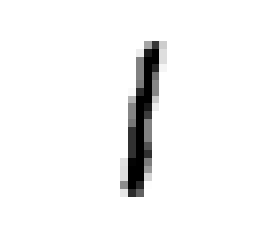

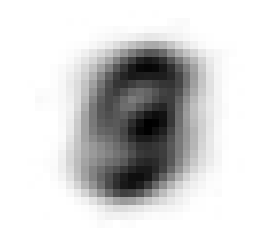

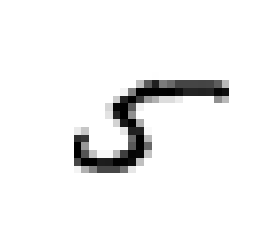

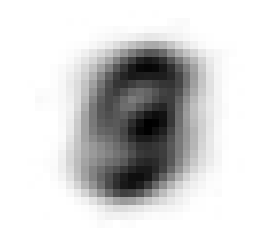

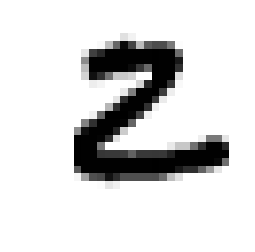

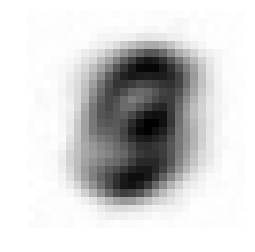

In [45]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o[0]):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)